In [1]:
import pandas as pd
# 1 million rows, np random state = 42
df_sample = pd.read_parquet("df_sample.parquet")

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -----------------------------------------
# Step 1: Define your dataset
# -----------------------------------------
X = df_sample.drop(columns=["total_amount"])
y = df_sample["total_amount"]

# -----------------------------------------
# Step 2: Train-test split
# -----------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------------------
# Step 3: Encode categorical columns (Ordinal)
# -----------------------------------------
categorical_cols = ["PU_DO_pair", "hour_bin"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols)
    ],
    remainder="passthrough"
)

# -----------------------------------------
# Step 4: Ridge regression pipeline
# -----------------------------------------
model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("ridge", Ridge(random_state=42))
])

# -----------------------------------------
# Step 5: Hyperparameter grid (alpha = regularization strength)
# -----------------------------------------
param_grid = {
    "ridge__alpha": np.logspace(-3, 3, 10)  # [0.001, 0.01, ..., 1000]
}

# -----------------------------------------
# Step 6: GridSearchCV
# -----------------------------------------
search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_absolute_error",
    verbose=1,
    n_jobs=-1
)

# -----------------------------------------
# Step 7: Fit the model
# -----------------------------------------
search.fit(X_train, y_train)
best_model = search.best_estimator_

# -----------------------------------------
# Step 8: Evaluate on test set
# -----------------------------------------
y_pred = best_model.predict(X_test)

print("Best alpha:", search.best_params_)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best alpha: {'ridge__alpha': 1000.0}
MAE: 2.336484721459242
RMSE: 4.277048386395573
R²: 0.8854172359770082


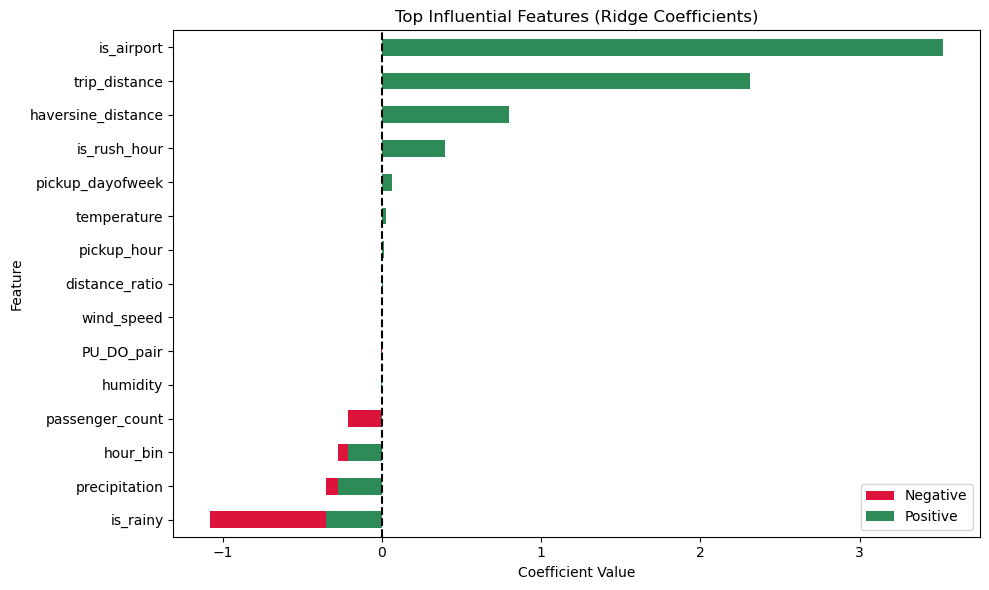

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Get feature names after preprocessing
encoded_features = best_model.named_steps['preprocess'].get_feature_names_out()

# Step 2: Get coefficients from the Ridge model
coefficients = best_model.named_steps['ridge'].coef_

# Step 3: Clean feature names (remove 'cat__' and 'remainder__')
clean_names = [name.split('__')[-1] for name in encoded_features]

# Step 4: Create Series and sort
coef_series = pd.Series(coefficients, index=clean_names).sort_values()

# Step 5: Plot top +/- 15 features
plt.figure(figsize=(10, 6))
coef_series.head(15).plot(kind='barh', color='crimson', label='Negative')
coef_series.tail(15).plot(kind='barh', color='seagreen', label='Positive')
plt.title("Top Influential Features (Ridge Coefficients)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.axvline(0, color='black', linestyle='--')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -----------------------------------------
# Step 2: Define target and features
# -----------------------------------------
X = df_sample.drop(columns=["total_amount"])
y = df_sample["total_amount"]

# -----------------------------------------
# Step 3: Train-test split
# -----------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------------------
# Step 4: Encode categorical columns (Ordinal)
# -----------------------------------------
categorical_cols = ["PU_DO_pair", "hour_bin"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical_cols)
    ],
    remainder="passthrough"
)

# -----------------------------------------
# Step 5: Random Forest model + pipeline
# -----------------------------------------
model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("rf", RandomForestRegressor(n_jobs=-1, random_state=42))
])

# -----------------------------------------
# Step 6: Set up parameter tuning
# -----------------------------------------
param_grid = {
    "rf__n_estimators": [100],
    "rf__max_depth": [10, 15, 20],
    "rf__min_samples_split": [2, 5],
    "rf__max_features": ["sqrt"]
}

search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_absolute_error",
    verbose=1,
    n_jobs=-1
)

# -----------------------------------------
# Step 7: Train the model
# -----------------------------------------
search.fit(X_train, y_train)
best_model = search.best_estimator_

# -----------------------------------------
# Step 8: Evaluate performance
# -----------------------------------------
y_pred = best_model.predict(X_test)

print("Best Params:", search.best_params_)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Extract encoded feature names and importances
encoded_features = best_model.named_steps['preprocess'].get_feature_names_out()
importances = best_model.named_steps['rf'].feature_importances_

# Step 2: Clean feature names (remove transformer prefixes)
clean_names = [name.split('__')[-1] for name in encoded_features]

# Step 3: Create and sort importance series
feat_imp = pd.Series(importances, index=clean_names).sort_values(ascending=False)

# Step 4: Plot top 20
plt.figure(figsize=(10,6))
feat_imp[:20].plot(kind='barh', color='cornflowerblue', edgecolor='black')
plt.title("Top Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

# -----------------------------------------
# Step 1: Define target and features
# -----------------------------------------
X = df_sample.drop(columns=["total_amount"])
y = df_sample["total_amount"]

# -----------------------------------------
# Step 2: Train-test split
# -----------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------------------
# Step 3: Categorical encoding (Ordinal)
# -----------------------------------------
categorical_cols = ["PU_DO_pair", "hour_bin"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical_cols)
    ],
    remainder="passthrough"
)

# -----------------------------------------
# Step 4: XGBoost model + pipeline
# -----------------------------------------
model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("xgb", XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        tree_method="hist",        # Use "gpu_hist" if using GPU
        n_jobs=-1
    ))
])

# -----------------------------------------
# Step 5: Parameter grid for tuning
# -----------------------------------------
param_grid = {
    "xgb__n_estimators": [100, 200],
    "xgb__max_depth": [5, 7, 10],
    "xgb__learning_rate": [0.01, 0.1],
    "xgb__subsample": [0.8, 1.0],
    "xgb__colsample_bytree": [0.8, 1.0]
}

# -----------------------------------------
# Step 6: GridSearchCV
# -----------------------------------------
search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_absolute_error",
    verbose=1,
    n_jobs=-1
)

# -----------------------------------------
# Step 7: Fit model
# -----------------------------------------
search.fit(X_train, y_train)
best_model = search.best_estimator_

# -----------------------------------------
# Step 8: Evaluate performance
# -----------------------------------------
y_pred = best_model.predict(X_test)

print("Best Params:", search.best_params_)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Get feature names after preprocessing
xgb_feature_names = best_model.named_steps["preprocess"].get_feature_names_out()

# Step 2: Get feature importances from the trained XGBoost model
importances = best_model.named_steps["xgb"].feature_importances_

# Step 3: Clean feature names (remove transformer prefixes)
clean_names = [name.split("__")[-1] for name in xgb_feature_names]

# Step 4: Create importance series
feat_imp = pd.Series(importances, index=clean_names).sort_values(ascending=False)

# Step 5: Plot top 20
plt.figure(figsize=(10, 6))
feat_imp[:20].plot(kind="barh", color='teal', edgecolor='black')
plt.title("Top Feature Importances (XGBoost)")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor

# -----------------------------------------
# Step 1: Dataset
# -----------------------------------------
X = df_sample.drop(columns=["total_amount"])
y = df_sample["total_amount"]

# -----------------------------------------
# Step 2: Train-test split
# -----------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------------------
# Step 3: Encode categorical features (Ordinal)
categorical_cols = ["PU_DO_pair", "hour_bin"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical_cols)
    ],
    remainder="passthrough"
)

# -----------------------------------------
# Step 4: Define pipeline with HistGradientBoosting
# -----------------------------------------
model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("hgb", HistGradientBoostingRegressor(
        random_state=42,
        verbose=0
    ))
])

# -----------------------------------------
# Step 5: Hyperparameter grid
# -----------------------------------------
param_grid = {
    "hgb__max_iter": [100, 200],
    "hgb__max_depth": [5, 10],
    "hgb__learning_rate": [0.01, 0.1],
    "hgb__l2_regularization": [0.0, 1.0]
}

# -----------------------------------------
# Step 6: GridSearchCV
# -----------------------------------------
search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_absolute_error",
    verbose=1,
    n_jobs=-1
)

# -----------------------------------------
# Step 7: Fit the model
# -----------------------------------------
search.fit(X_train, y_train)
best_model = search.best_estimator_

# -----------------------------------------
# Step 8: Evaluate performance
# -----------------------------------------
y_pred = best_model.predict(X_test)

print("Best Params:", search.best_params_)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# -----------------------------------------
# Step 1: Compute permutation importance
# -----------------------------------------
result = permutation_importance(
    estimator=best_model,
    X=X_test,
    y=y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# -----------------------------------------
# Step 2: Get feature names from preprocessor
# -----------------------------------------
encoded_features = best_model.named_steps["preprocess"].get_feature_names_out()
clean_names = [name.split("__")[-1] for name in encoded_features]

# -----------------------------------------
# Step 3: Create a Series of importances
# -----------------------------------------
perm_importance = pd.Series(result.importances_mean, index=clean_names).sort_values(ascending=False)

# -----------------------------------------
# Step 4: Plot top 20 important features
# -----------------------------------------
plt.figure(figsize=(10, 6))
perm_importance[:20].plot(kind='barh', color='darkorange', edgecolor='black')
plt.title("Top Feature Importances (Permutation - HistGBM)")
plt.xlabel("Mean Importance Score")
plt.gca().invert_yaxis()
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
